# Time series forecasting

In [42]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We will use [sktime](https://www.sktime.net/en/stable/index.html) as our main library for time series. It offers interface very similar to scikit-learn, and conveniently wraps many other libraries, for example:
- [statsforecast](https://github.com/Nixtla/statsforecast) - efficient implementations of many forecasting methods, e.g. AutoARIMA and AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - statistical tests for time series and another AutoARIMA implementation
- [statsmodels](https://www.statsmodels.org/stable/index.html) - a few time series decomposition and forecasting methods

For statistical tests we will use [scipy](https://docs.scipy.org/doc/scipy/index.html) and [statsmodels](https://www.statsmodels.org/stable/index.html).

## Forecasting Polish inflation

The problem of forecasting inflation (here defined using consumer price index, CPI) is very common, done by basically every country and larger financial institutions. In practice it's not a single task, but rather a collection of related problems, forecasting e.g. inflation, core inflation (excluding most volatile components, e.g. food and energy prices), and other formulations.

In Poland, basic data about inflation [is published by the Central Statistical Office of Poland (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), with monthly, quarterly, half-yearly and yearly frequency. More detailed information is published by other institutions, because they depend on the methodology used, e.g. core inflation [is calculated and published by the National Bank of Poland (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Forecasting inflation is a challenge, since it typically:
- has visible cycles, but very irregular
- is implicitly tied to many external factors (global economy, political decisions etc.)
- there is no apparent seasonality
- we are interested in forecasting with many frequencies, e.g. monthly (short-term decisions) and yearly (long-term decisions)

We will use GUS data with monthly frequency. To get a percentage value (annual percentage rate inflation) from the raw data, we need to subtract 100 from provided values.

In [43]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100

# filter out NaN values from the end of the series
df = df[~df.isna()]

df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2024-04      2.4
2024-05      2.5
2024-06      2.6
2024-07      4.2
2024-08      4.3
Freq: M, Name: value, Length: 512, dtype: float64

To plot the time series, the easiest way is to use the [plot_series() function](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html) from sktime, which will automatically nicely format X and Y axes.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation'}, ylabel='value'>)

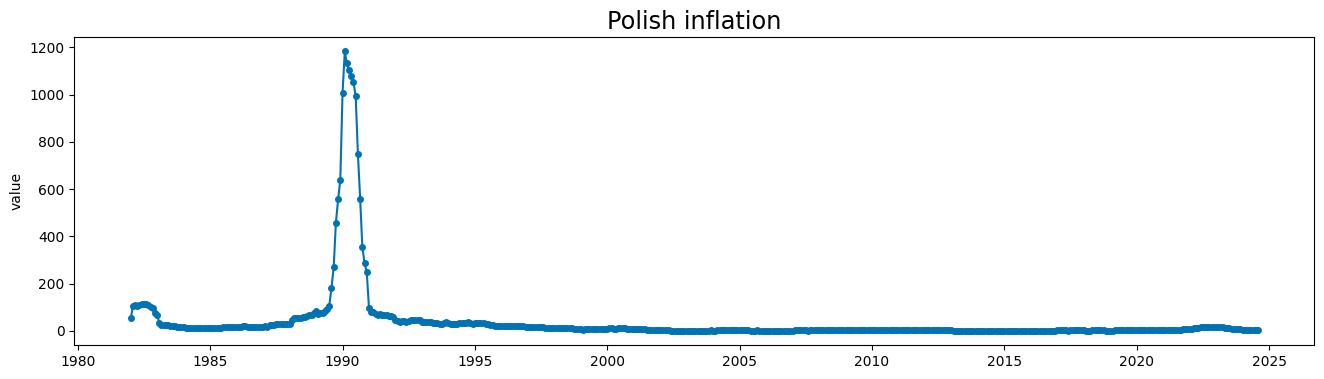

In [44]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

There is no error here - 90s were a particularly interesting period, with [hyperinflation](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), later ["shock therapy"](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) and implementation of the [Balcerowicz Plan](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). From the perspective of time series forecasting, this is definitely na outlier, but quite long. For this reason, we will limit ourselves to post-2000 data.

Similar behavior can often be seen in time series data, related to e.g. [2007-2008 financial crisis](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis) or COVID-19 pandemic. Such events can introduce shocks with long effects, and using only later data is arguably the simplest strategy to deal with this.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation, from year 2000'}, ylabel='value'>)

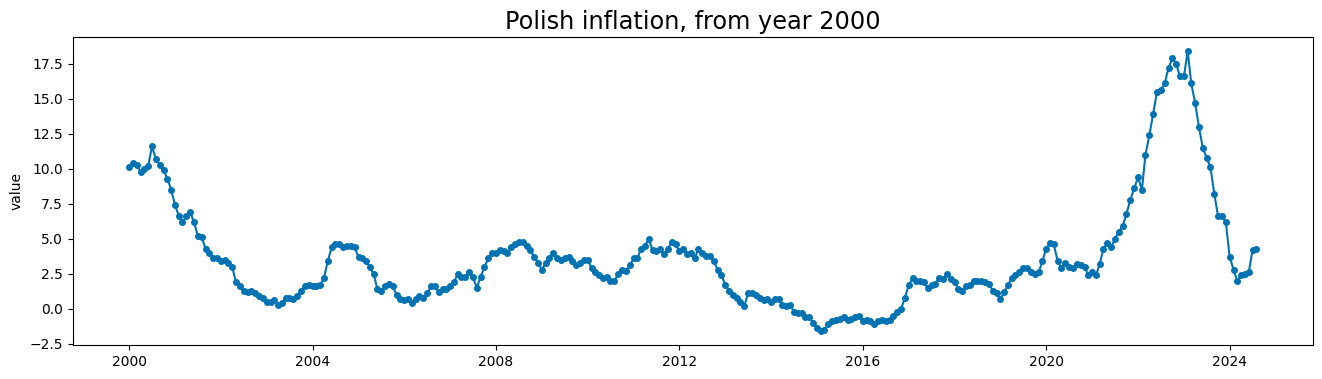

In [45]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000")

There is definitely some information here, with cycles and trends. Fortunately, the data seems to be changing reasonably slowly most of the time. But what about seasonality?

**Exercise 1 (0.5 points)**

Implement the `plot_stl_decomposition` function. Use `STLTransformer` to compute the STL decomposition ([documentation](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Remember to use appropriate arguments to set the seasonality period and return all three components.

Plot the resulting STL decomposition. Comment:
- do you see a yearly seasonality here?
- concerning residuals, are they only a white noise, or do they seem to contain some further information to use?

In [46]:
from sktime.transformations.series.detrend import STLTransformer


def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    transformer = STLTransformer(sp=seasonal_period, return_components=True)
    data_transformed = transformer.fit_transform(data)
    fig, ax = plt.subplots(4, 1, figsize=(12, 8))
    
    ax[0].plot(data)
    ax[0].set_title("Original series")

    ax[1].plot(data_transformed.trend)
    ax[1].set_title("Trend")

    ax[2].plot(data_transformed.seasonal)
    ax[2].set_title("Seasonal")

    ax[3].plot(data_transformed.resid)
    ax[3].set_title("Residual")
    print("Overall mean of residuals:", data_transformed.resid.mean())

    for time in np.array_split(data_transformed.resid, 12):
        print(f"Monthly var: {round(time.var(), 2)} and mean: {round(time.mean(),2)}")

    plt.tight_layout()
    plt.show()

In [47]:
df_timestamp_series = df.copy()
df_timestamp_series.index = df_timestamp_series.index.to_timestamp()

Overall mean of residuals: 0.012471440605233107
Monthly var: 0.25 and mean: -0.03
Monthly var: 0.16 and mean: -0.18
Monthly var: 0.34 and mean: 0.09
Monthly var: 0.16 and mean: -0.02
Monthly var: 0.19 and mean: 0.05
Monthly var: 0.17 and mean: 0.03
Monthly var: 0.14 and mean: 0.02
Monthly var: 0.07 and mean: -0.15
Monthly var: 0.21 and mean: 0.1
Monthly var: 0.38 and mean: -0.01
Monthly var: 0.48 and mean: -0.24
Monthly var: 2.13 and mean: 0.49


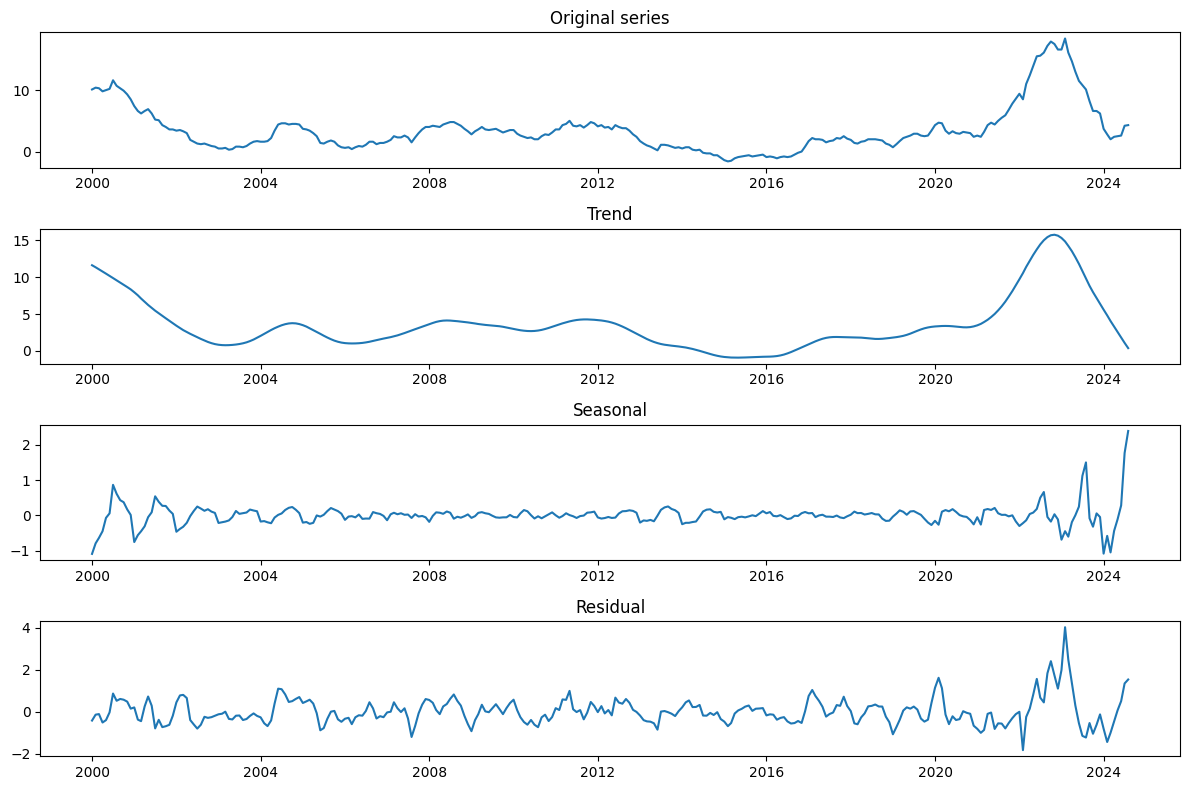

In [48]:
plot_stl_decomposition(df_timestamp_series)

- do you see a yearly seasonality here? \
    **Yes, I see between 2000 and 2004 clearly visible peaks. And this is the same for 2020-2024. For other periods it is harder to notice them, but they are also visible.**
- concerning residuals, are they only a white noise, or do they seem to contain some further information to use?\
    **Mean of residuals is around 0 so they are unbiased. Also I don't see any significant correlation in data.**

Manual check using STL decomposition is useful - this allows us to gain intuition and knowledge about the data, and validation parameters. Of course we also have automated procedures, using statistical tests, to avoid such manual labor when we can.

Let's check the seasonality and stationarity of our data. This is not strictly necessary for ETS models - they use the data as-is. However, the ARIMA models require stationary data, and knowledge about seasonality, or lack thereof, can greatly accelerate our experiments. SARIMA takes much longer than simpler ARIMA.

**Exercise 2 (0.75 points)**

1. Check, using statistical tests for seasonality, if there is a quarterly, half-yearly, or yearly seasonality in the data. Use the `nsdiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html)). If you detect seasonality, remove it using the `Differencer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) and plot the deasonalized series.

2. Check, using statistical tests for stationarity, what differencing order stationarizes the data. Use the `ndiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)). If it's greater than zero, i.e. differencing is necessary, then stationarize the series using the `Differencer` class and plot the resulting time series.

3. Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.

Use the default `D_max` and `d_max` values.

**Warning:** create new variables for values after differencing, do not overwrite the `df` variable. It will be used later.

In [49]:
from pmdarima.arima import ARIMA
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs

### Seasonality

In [50]:
nsdiffs(df, m=4)

0

In [51]:
nsdiffs(df, m=2)

0

In [52]:
nsdiffs(df, m=12)

0

### Stationarity

In [53]:
ndiffs(df)

1

In [54]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=[2, 4, 12])
df_transformed = transformer.fit_transform(df)

In [55]:
ndiffs(df_transformed)

0

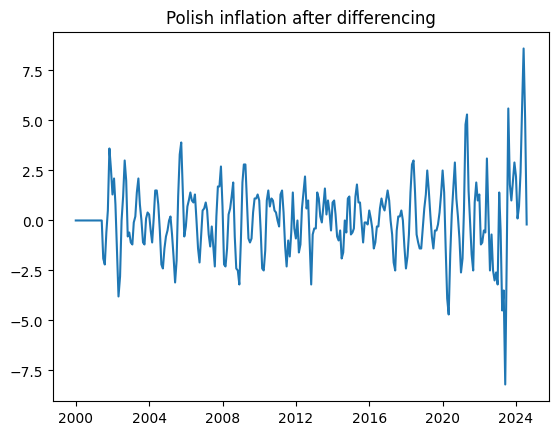

In [56]:
df_transformed_timestamp_series = df_transformed.copy()
df_transformed_timestamp_series.index = df_transformed_timestamp_series.index.to_timestamp()
plt.plot(df_transformed_timestamp_series)
plt.title("Polish inflation after differencing")
plt.show()

3. Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.\
    **Tests detected that data was non-stationary, so I would choose ARIMA, because I(d) will introduce differencing.\
    After differencing I could use ARMA. Data hasn't got seasonality so SARIMA is not proper.**

We are now basically ready to train our forecasting models. We will use 20% of the newest data for testing, using the expanding window strategy, with step 1 (we get inflation reading each month). MAE and MASE will be used as quality metrics.

We will also perform residuals analysis. Errors should be normally distributed (unbiased mdoel) and do not have autocorrelation (model utilizing all available information). For all statistical tests we assume the significance level $\alpha = 0.05$.

For testing normality, the Anderson-Darling test is less conservative than Shapiro-Wilk test, which is quite useful in practice. Errors are very rarely close to "true" normality in real world. The null hypothesis is that values come from the given distributions (by default the normal one), and alternative hypothesis that they come from other distribution.

For testing error autocorrelation, the Ljung-Box test is used, which tests autocorrelation for various lags. For each lag, a separate test is performed. The null hypothesis is the lack of autocorrelation, and the alternative hypothesis is that there is an autocorrelation with a given lag.

**Exercise 3 (1.5 points)**

Implement the missing parts of the `evaluate_model` function:
1. Create `ExpandingWindowSplitter` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.ExpandingWindowSplitter.html)), which should start testing at 80% of data. The forecast window size is controlled via the `horizon` parameter.
2. Create a list of metric objects, consisting of MAE and MASE ([ocumentation](https://www.sktime.net/en/latest/api_reference/performance_metrics.html)).
3. Perform the model evaluation, using the `evaluate` function ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Pass `return_data=True`, in order to also return the computed forecasts. It returns a DataFrame with results.
4. Calculate average metric values, using the resulting DataFrame. Print them rounded to 2 decimal places.
5. Taking into consideration the `analyze_residuals` argument, perform the error analysis:
   - calculate residuals $y - \hat{y}$
   - plot the residuals histogram
   - perform the Anderson-Darling test ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)) and print whether the distribution is normal or not
   - perform the Ljung-Box test ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)) and print the test results

Test the function, using two baseline forecasting methods: average (mean) and last known value. Use the `NaiveForecaster` class ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), with 3 months forecasting horizon. Plot the forecasts, using the `plot_forecasts` argument.

In [57]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteScaledError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from statsmodels.stats.diagnostic import acorr_ljungbox

def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    cv = ExpandingWindowSplitter(fh=np.arange(1, horizon+1), initial_window=int(len(data)*0.8), step_length=horizon)
    metrics = [MeanAbsoluteError(), MeanAbsoluteScaledError(), MeanAbsolutePercentageError()]
    results = evaluate(model, cv, data, scoring=metrics, return_data=True)
    mae = round(np.mean(results["test_MeanAbsoluteError"]), 2)
    mase = round(np.mean(results["test_MeanAbsoluteScaledError"]), 2)

    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")
    
    y_pred = pd.concat(results["y_pred"].values)
    y_pred = y_pred.sort_index()

    if plot_forecasts:
        y_true = data[y_pred.index]
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        residuals = y_true - y_pred
        residuals.hist(bins=20)
        plt.title("Histogram of residuals")
        plt.show()

        anderson_test = anderson(residuals)
        print(f"Anderson-Darling test: {anderson_test}")
        print("=========================================")
        ljung_box_test = acorr_ljungbox(residuals, lags=[12], return_df=True)
        print(f"Ljung-Box test: {ljung_box_test}")
        



MAE: 4.81
MASE: 14.05


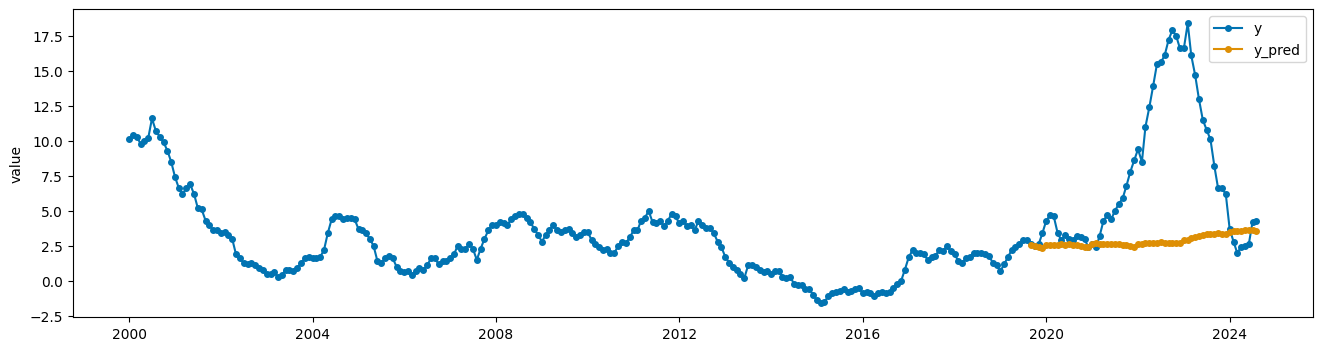

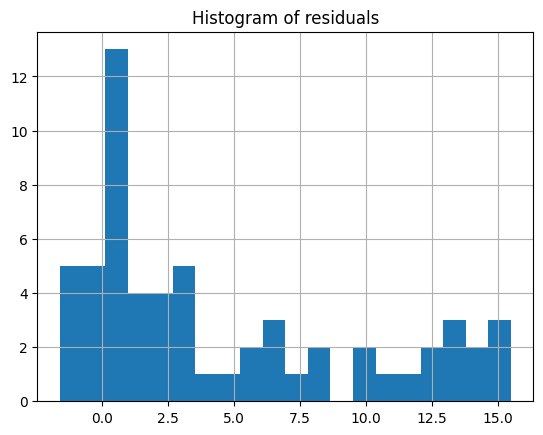

Anderson-Darling test: AndersonResult(statistic=3.3593181037301605, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.61235521403971, scale=5.277728180792686)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  301.809455  1.957832e-57


In [58]:
from sktime.forecasting.naive import NaiveForecaster
month_period = 3

model_mean = NaiveForecaster(strategy="mean", sp=12)
evaluate_model(model_mean, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

MAE: 5.50
MASE: 15.60


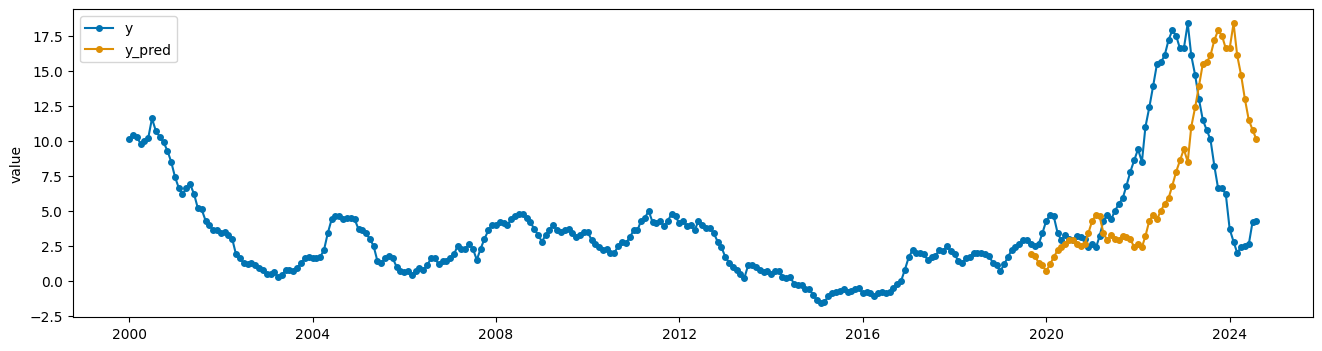

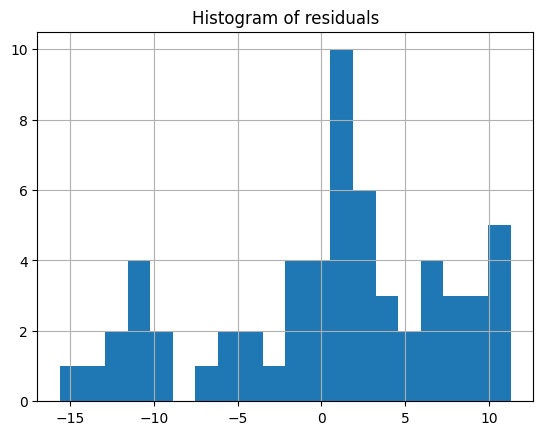

Anderson-Darling test: AndersonResult(statistic=0.9859736580251095, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4899999999999996, scale=7.023584965152188)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  270.43915  7.364420e-51


In [59]:
model_last = NaiveForecaster(strategy="last", sp=12)
evaluate_model(model_last, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

Results from our first baselines look reasonable. Let's see how ETS and ARIMA will compare.

**Exercise 4 (0.75 points)**

1. Perform forecasting using the AutoETS algorithm in the damped trend variant, based on the `statsforecast` implementation ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoETS.html)). Plot forecasts and perform residuals analysis.
2. Similarly, use AutoARIMA for forecasting ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoARIMA.html)). If you didn't detect seasonality earlier, pass appropriate option to ignore SARIMA variants.
3. Comment on the results:
   - did you manage to outperform the baselines?
   - which of the models is better, and what may this mean?
   - which model is correct, at least approximately, i.e. has normally distributed, non-autocorrelated errors?
   - are the results of the best model, subjectively, good enough?

As before, use 3 month forecast horizon.

In [ ]:
from sktime.forecasting.statsforecast import StatsForecastAutoETS, StatsForecastAutoARIMA

MAE: 1.28
MASE: 3.76


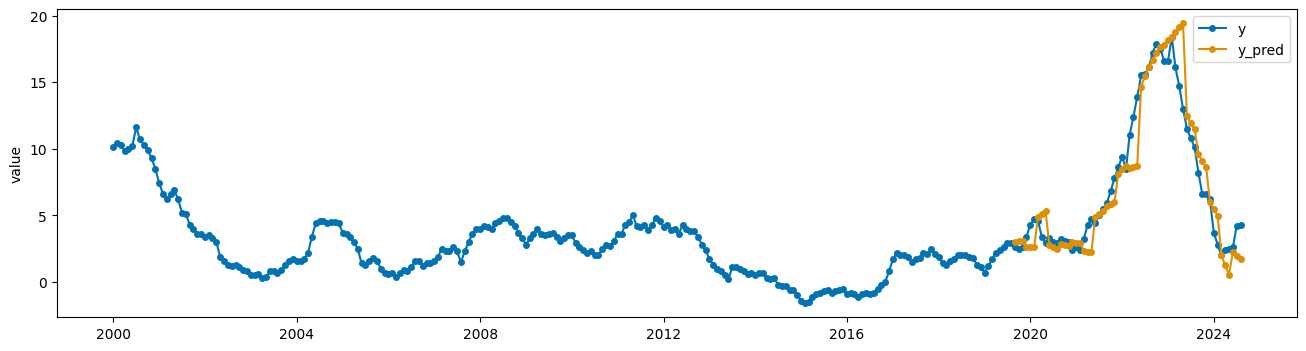

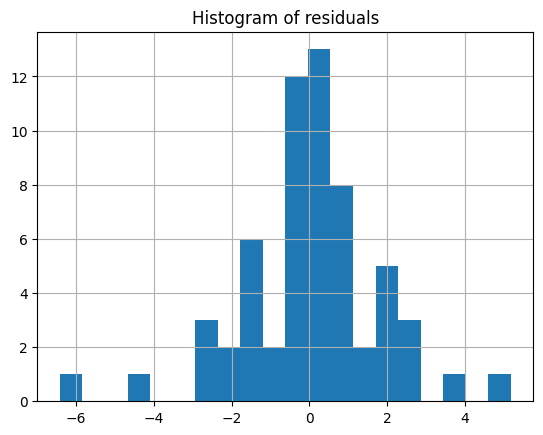

Anderson-Darling test: AndersonResult(statistic=0.8397238023560334, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.015026946914480336, scale=1.8238061079390164)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  60.367134  1.934813e-08


In [61]:
model_ets = StatsForecastAutoETS(damped=True, season_length=12)
evaluate_model(model_ets, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

MAE: 1.11
MASE: 3.29


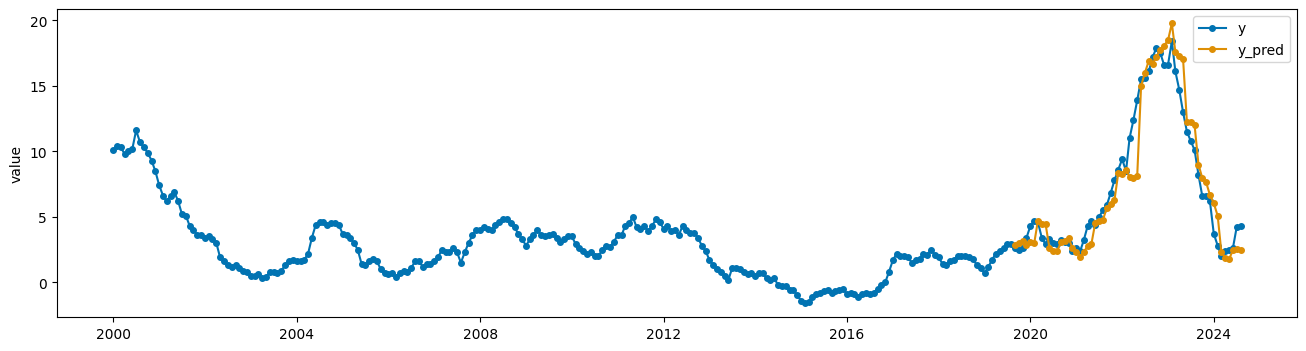

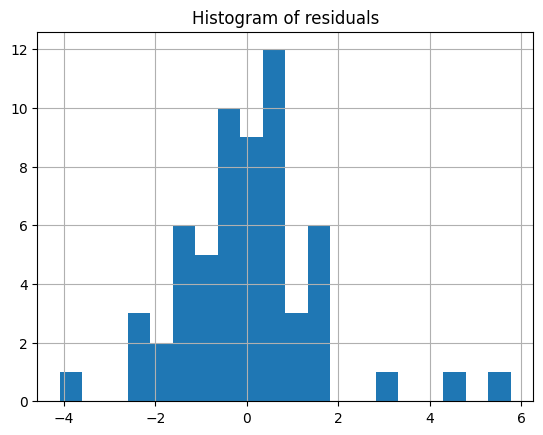

Anderson-Darling test: AndersonResult(statistic=0.9051383148869476, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.052084630493797725, scale=1.573253724740218)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  58.422849  4.369000e-08


In [63]:
model_arima = StatsForecastAutoARIMA(sp=12)
evaluate_model(model_arima, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

Comment on the results:
   - did you manage to outperform the baselines?\
        **Yes, even significantly. MAE score for ARIMA achieved value 1.11 which is few point less than in baselines.**
   - which of the models is better, and what may this mean?\
      **Arima gave slightly better results. Maybe because in ETS past values have lower importance, but ARIMA takes the whole scope into account.**
   - which model is correct, at least approximately, i.e. has normally distributed, non-autocorrelated errors?\
      **All models passed Anderson-Darling test and both have not passed Ljung-Box test, so they are normally distributed and the data is autocorrelated.**
   - are the results of the best model, subjectively, good enough?\
      **I think that yes, they are good to some degree and will give valuable information in some areas.**

3 month horizon is quite short, generally speaking. The question is, what about long-term forecasting, e.g. half-yearly or yearly? They are equally, or even more interesting and relevant, e.g. for national budget planning.

**Exercise 5 (0.75 points)**

Perform forecasting for 6-month and yearly horizons, using:
- both baselines
- ETS
- ARIMA

For the best model, plot the forecasts and perform residuals analysis.

Comment:
- are there differences between models, compared to the 3-month forecasting?
- how does the quality of forecasts change for longer horizons?
- in your opinion, are those models useful at all for long-term forecasting?

In [ ]:
def forecast(month_period):

    evaluate_model(model_mean, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

    evaluate_model(model_last, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

    evaluate_model(model_ets, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

    evaluate_model(model_arima, df, horizon=month_period, plot_forecasts=True, analyze_residuals=True)

MAE: 4.81
MASE: 14.24


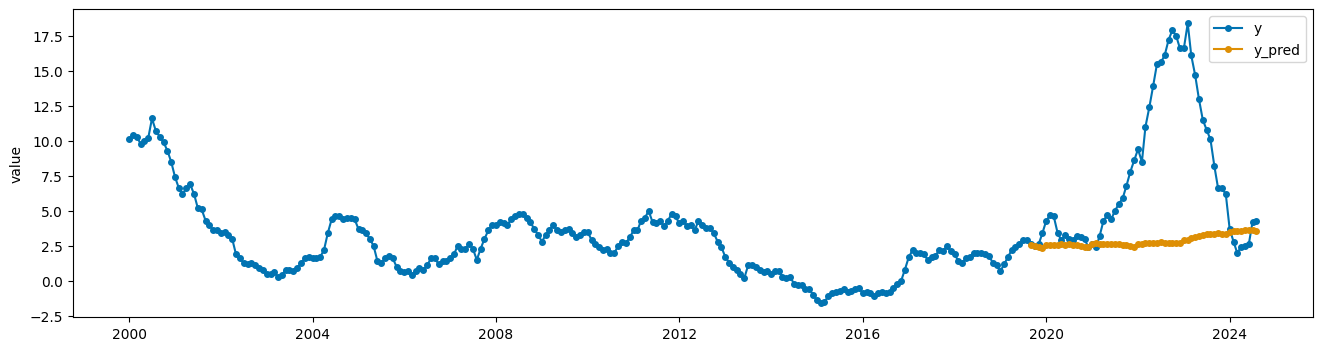

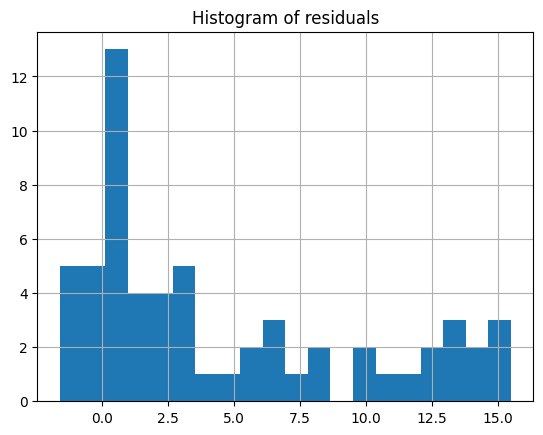

Anderson-Darling test: AndersonResult(statistic=3.3593181037301605, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.61235521403971, scale=5.277728180792686)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  301.809455  1.957832e-57
MAE: 5.50
MASE: 15.78


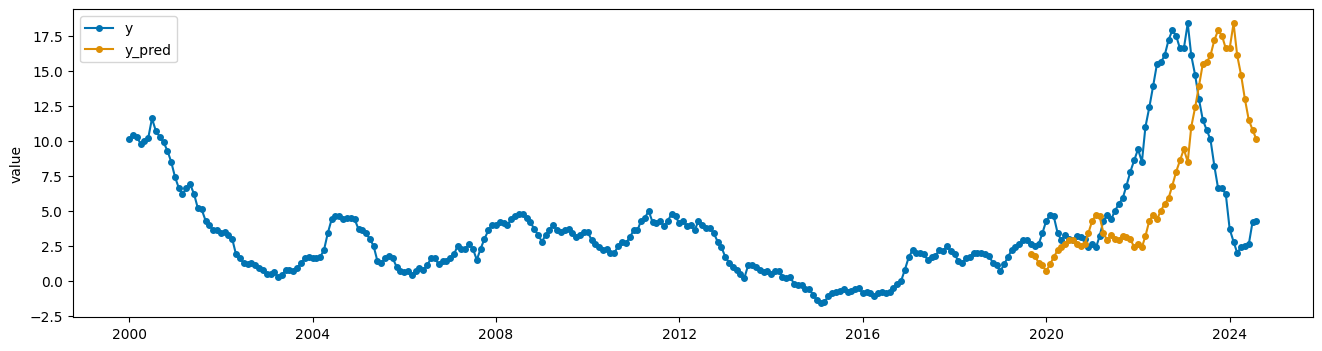

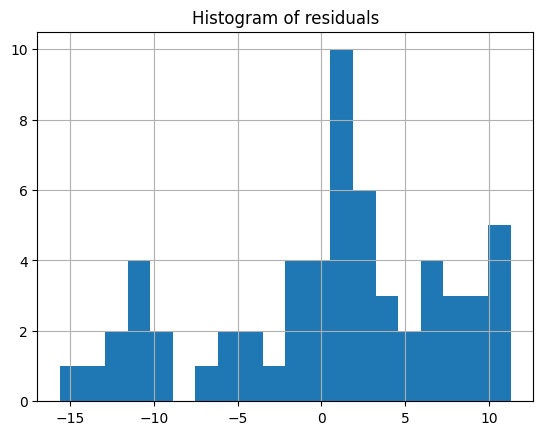

Anderson-Darling test: AndersonResult(statistic=0.9859736580251095, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4899999999999996, scale=7.023584965152188)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  270.43915  7.364420e-51
MAE: 2.56
MASE: 7.54


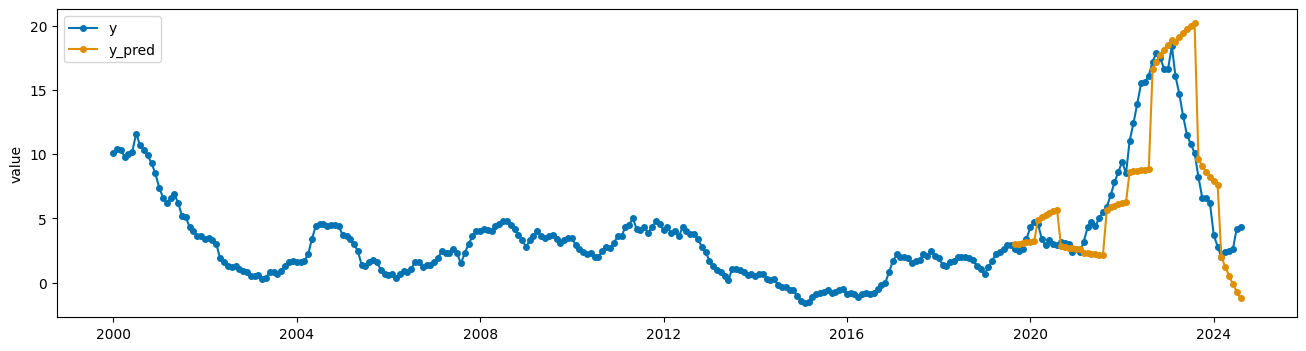

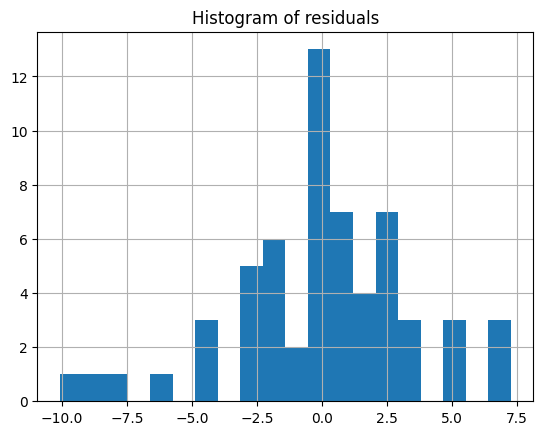

Anderson-Darling test: AndersonResult(statistic=0.7256064236423256, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.03619836046287158, scale=3.528941549891019)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  136.962477  2.455036e-23
MAE: 2.06
MASE: 6.12


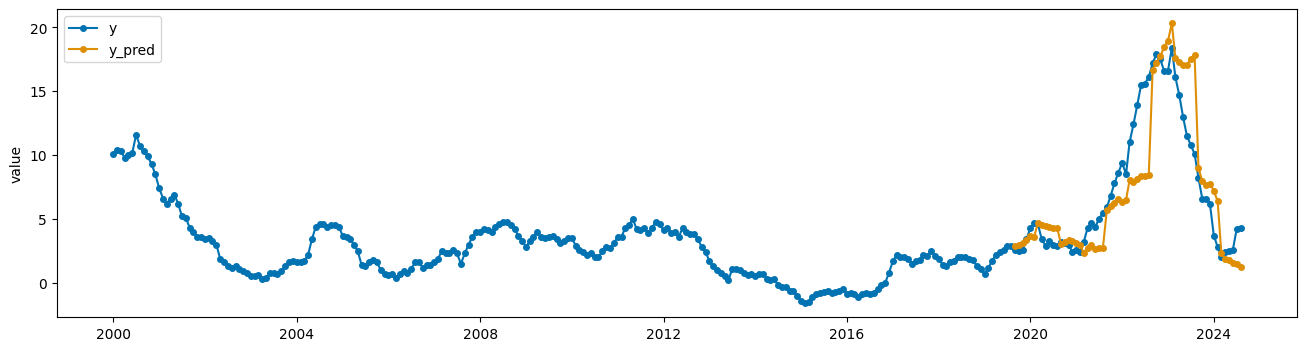

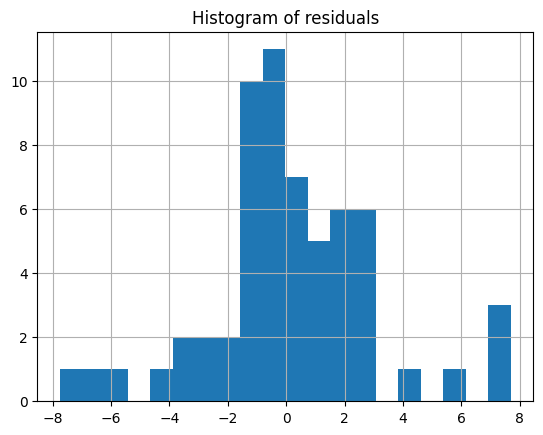

Anderson-Darling test: AndersonResult(statistic=1.0147201013298215, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.16762003611452417, scale=2.917127775024971)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  131.431309  3.184317e-22


In [65]:
forecast(6)

MAE: 4.81
MASE: 14.45


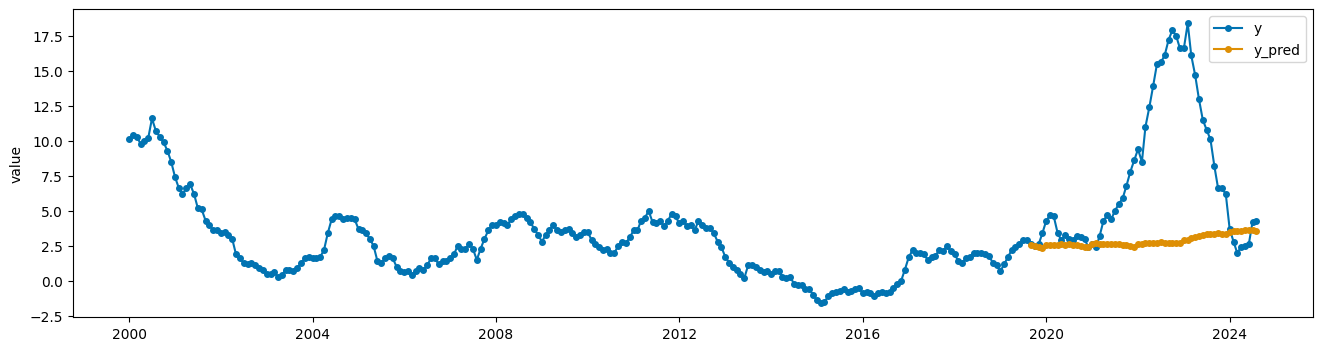

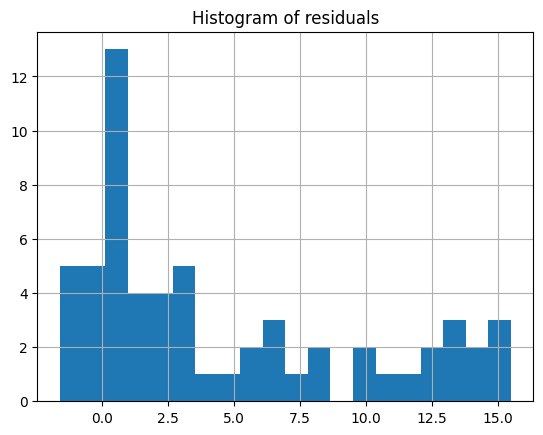

Anderson-Darling test: AndersonResult(statistic=3.3593181037301605, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.61235521403971, scale=5.277728180792686)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  301.809455  1.957832e-57
MAE: 5.50
MASE: 16.02


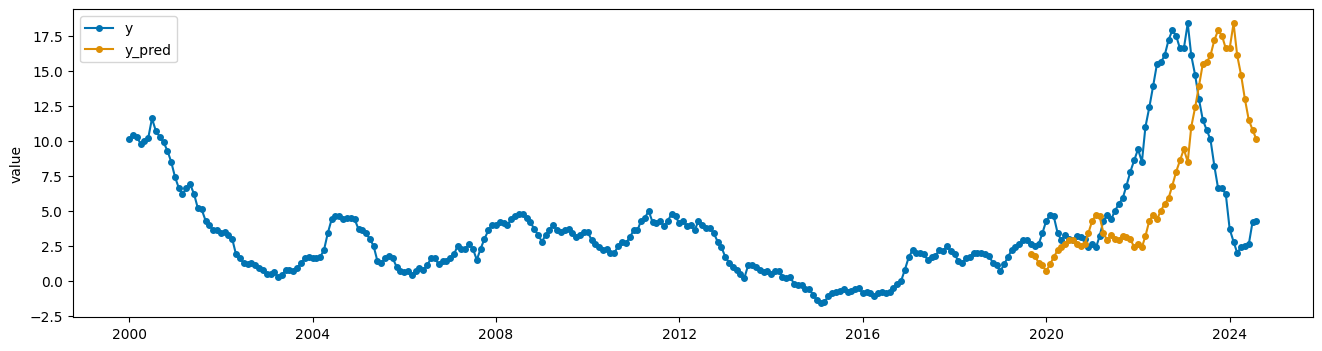

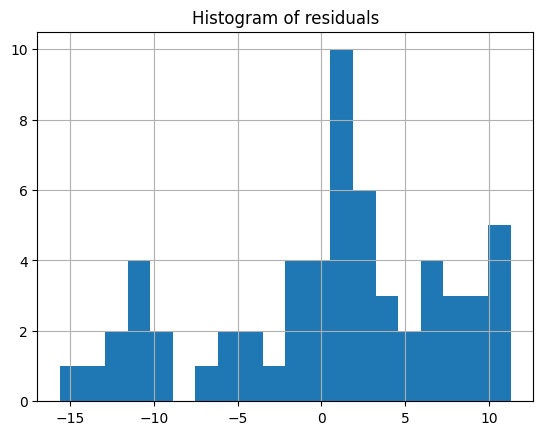

Anderson-Darling test: AndersonResult(statistic=0.9859736580251095, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4899999999999996, scale=7.023584965152188)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  270.43915  7.364420e-51
MAE: 2.76
MASE: 8.21


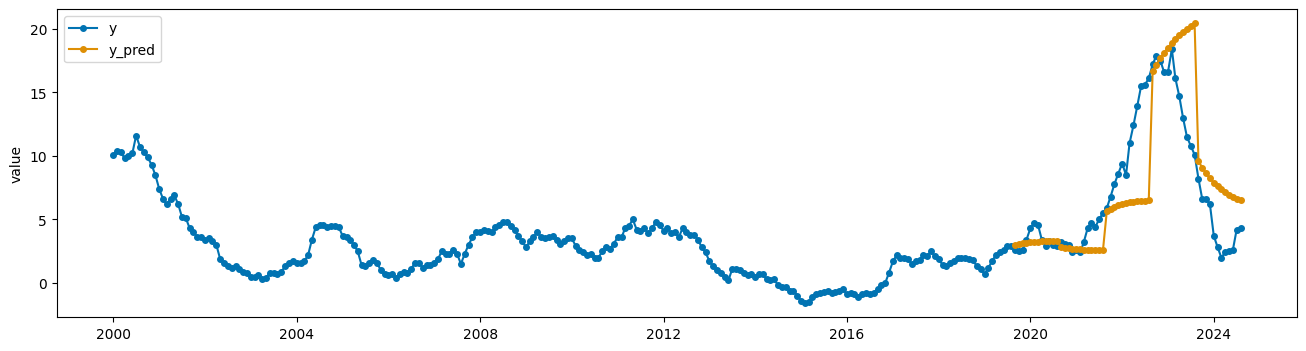

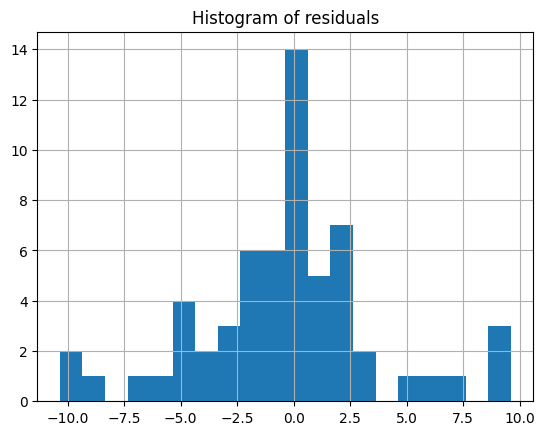

Anderson-Darling test: AndersonResult(statistic=1.2312988750022882, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.25933783972656305, scale=3.983429844098436)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  158.620459  1.003155e-27
MAE: 2.65
MASE: 7.87


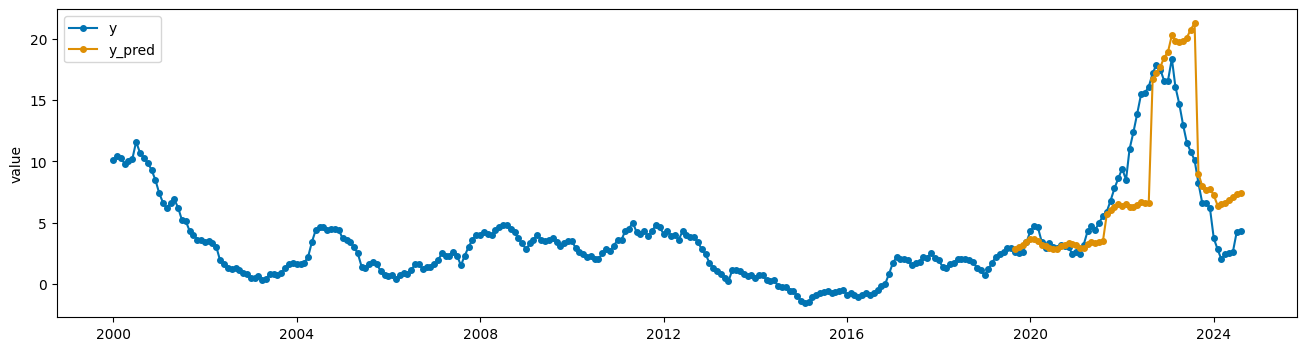

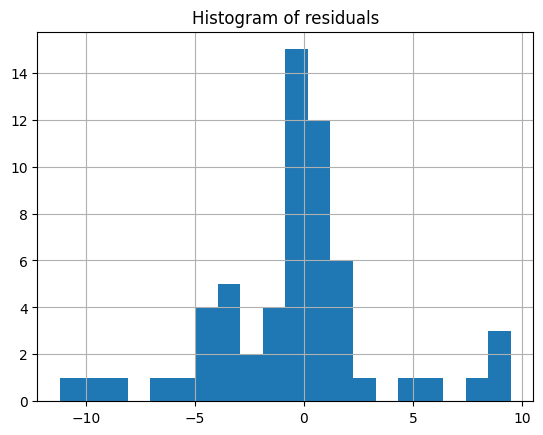

Anderson-Darling test: AndersonResult(statistic=1.7256104507048633, critical_values=array([0.544, 0.619, 0.743, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.39539324571437723, scale=3.94250770558395)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  139.53488  7.434702e-24


In [66]:
forecast(12)

- are there differences between models, compared to the 3-month forecasting?\
    **Yes, because forecasting period is much longer, the results got worse.**
- how does the quality of forecasts change for longer horizons?\
    **Quality has changed in two ways. First of all the longer it predicts the more uncertain model is and gives worse results.\
    Also there are more significant thresholds visible between forecasted periods which gives strange and shattered data.**
- in your opinion, are those models useful at all for long-term forecasting?\
    **Based on these examples, longer periods than 3 months they cannot predict. They seem to be useful only for short-term forecasting.**

## Forecasting network traffic

And now for something completely different. Network traffic forecasting is necessary for virtual machines (VMs) scaling, adding more servers to handle load in parallel. This is done more and more frequently by using ML models, based on time series forecasting, to scale more intelligently and avoid manually tweaking scaling rules. This is called predictive scaling, and is implemented by e.g. [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling), and [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive). There are also solutions for Kubernetes, both [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/) and [proprietary](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Time series forecasting allows lower latency and lower costs, automatically turning off machines when low demand is predicted.

Wikipedia and Google hosted [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting), where the goal was predicting the network traffic on particular Wikipedia pages. It's a really massive dataset, so we will operate on a simplified problem, where we have a total number of requests to the Wikipedia domain in millions.

Typical characteristics of such tasks are:
- short-term forecasting
- high frequency
- dynamically changing, noisy data (e.g. bot activity, web scraping)
- frequent model retraining
- high need for automatization, lack of manual model analysis

2015-07-01    148.672476
2015-07-02    149.593840
2015-07-03    141.164198
2015-07-04    145.612937
2015-07-05    151.495372
                 ...    
2017-09-06    172.354146
2017-09-07    180.731284
2017-09-08    136.754670
2017-09-09    132.359512
2017-09-10    141.863949
Freq: D, Name: value, Length: 803, dtype: float64

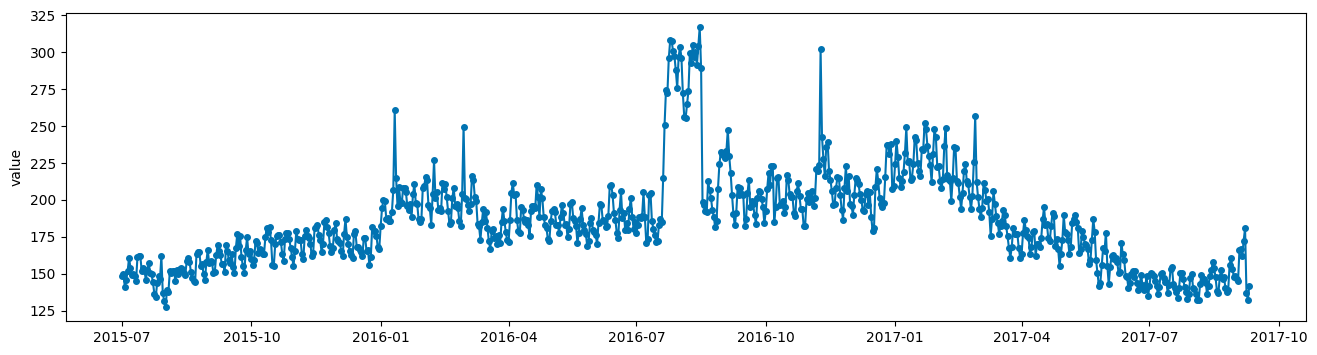

In [67]:
df = pd.read_parquet("wikipedia_traffic.parquet")
df = df.set_index("date").to_period(freq="d")
df = df["value"]
plot_series(df)
df

**Exercise 6 (1 point)**

For 1-day horizon, train models and evaluate them (similarly to the previous dataset, with 20% test data):
- two baselines
- ETS with damped trend
- ARIMA (without seasonality)
- SARIMA

Comment:
- based on those results, is there a seasonality here?
- did you manage to outperform the baseline?

MAE: 33.45
MASE: 3.97


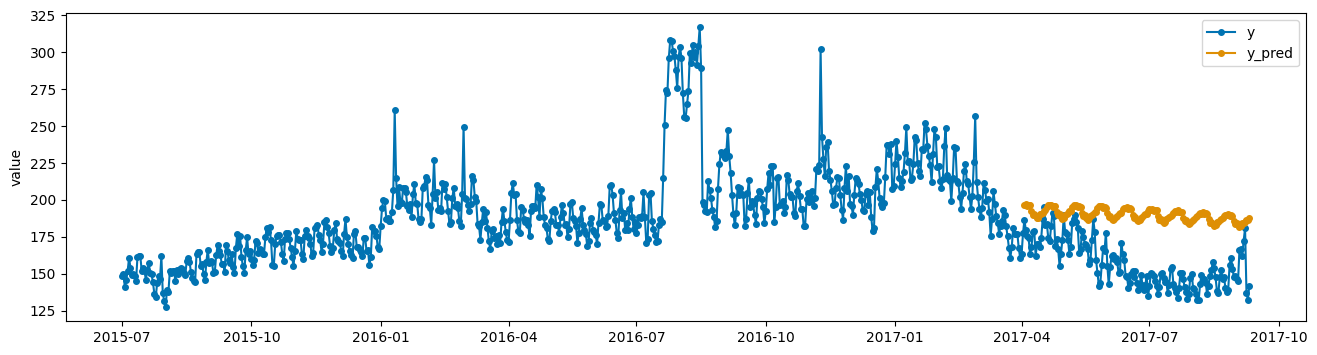

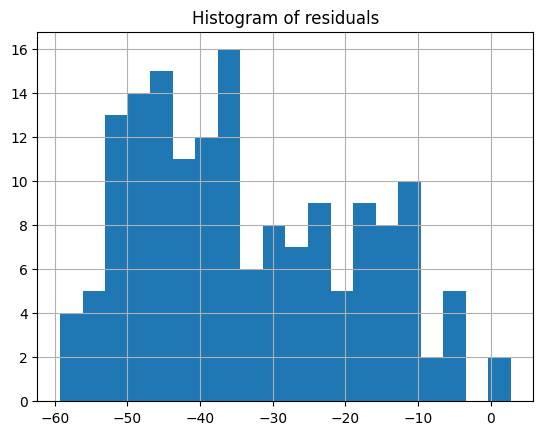

Anderson-Darling test: AndersonResult(statistic=2.066822009398493, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-33.3872222570716, scale=14.906987097321421)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat      lb_pvalue
12  612.378717  2.407393e-123


In [68]:
forecast_horizon = 1 #int(len(df)*0.2)

# first baseline
model_mean = NaiveForecaster(strategy="mean", sp=18)
evaluate_model(model_mean, df, horizon=forecast_horizon, plot_forecasts=True, analyze_residuals=True)

MAE: 14.48
MASE: 1.71


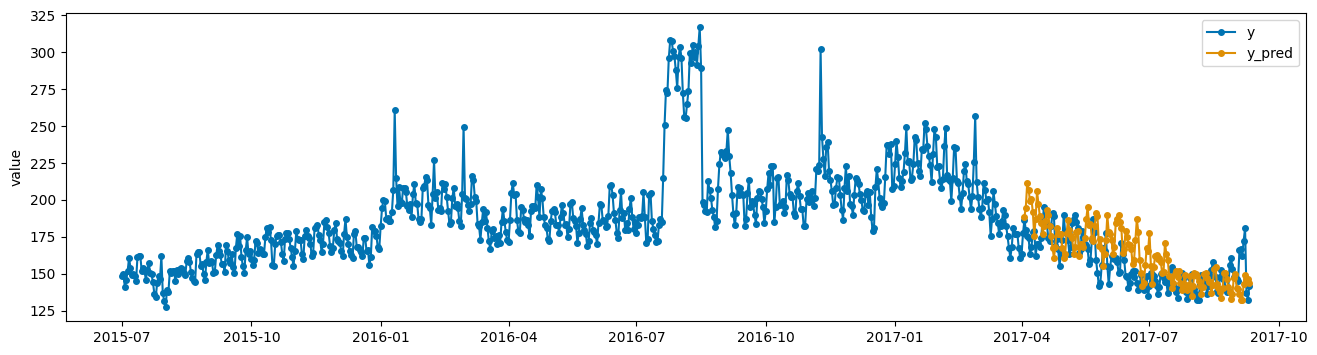

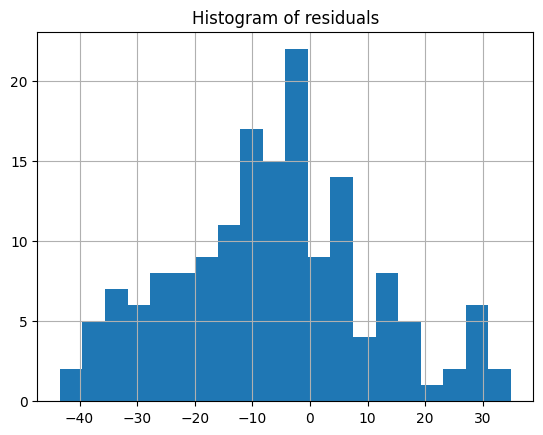

Anderson-Darling test: AndersonResult(statistic=0.3992680150612671, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-6.546221795031057, scale=17.045317224422377)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  276.765059  3.493963e-52


In [69]:
# second baseline
model_last = NaiveForecaster(strategy="last", sp=31)
evaluate_model(model_last, df, horizon=forecast_horizon, plot_forecasts=True, analyze_residuals=True)

MAE: 6.63
MASE: 0.78


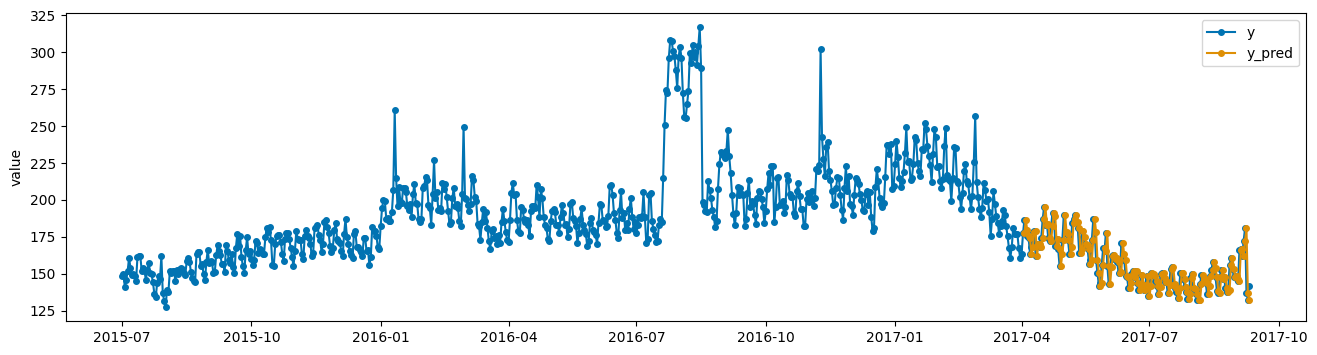

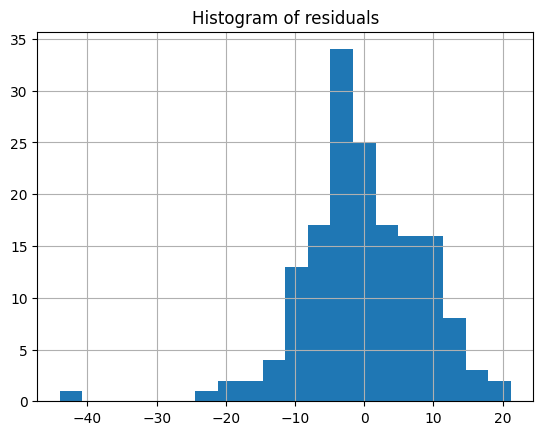

Anderson-Darling test: AndersonResult(statistic=0.7436144761241223, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.2183668356577107, scale=8.720524016445898)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  117.035922  2.406015e-19


In [ ]:

# ETS
from sktime.forecasting.base import ForecastingHorizon

model_ets = StatsForecastAutoETS(damped=True, season_length=31)
evaluate_model(model_ets, df, horizon=forecast_horizon, plot_forecasts=True, analyze_residuals=True)

MAE: 5.69
MASE: 0.67


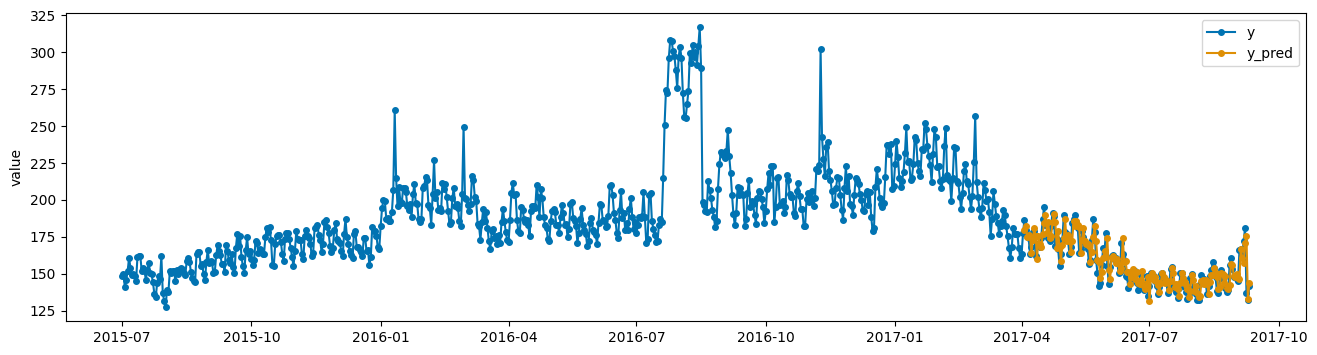

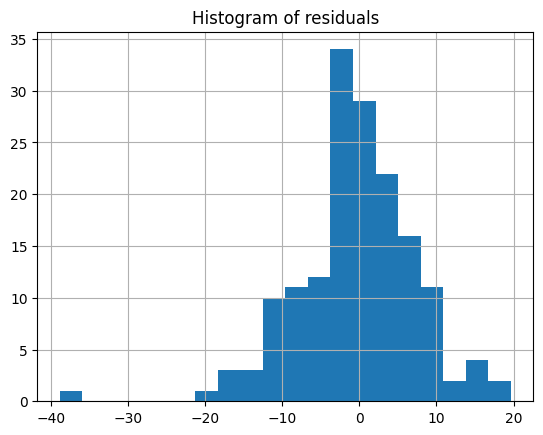

Anderson-Darling test: AndersonResult(statistic=0.8353513212434791, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.44221167130179817, scale=7.713208270289621)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:      lb_stat     lb_pvalue
12  64.49792  3.375397e-09


In [ ]:
# ARIMA
model_arima = StatsForecastAutoARIMA(sp=31)
evaluate_model(model_arima, df, horizon=forecast_horizon, plot_forecasts=True, analyze_residuals=True)

MAE: 5.69
MASE: 0.67


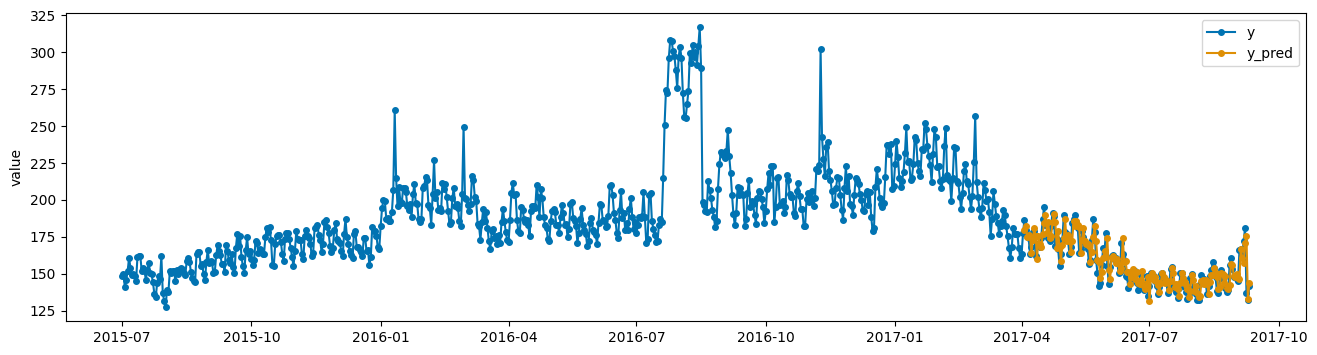

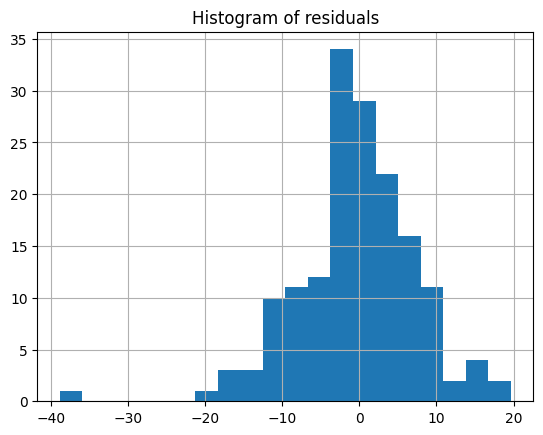

Anderson-Darling test: AndersonResult(statistic=0.8353513212434791, critical_values=array([0.563, 0.641, 0.769, 0.897, 1.067]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.44221167130179817, scale=7.713208270289621)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:      lb_stat     lb_pvalue
12  64.49792  3.375397e-09


In [72]:
# SARIMA
model_sarima = StatsForecastAutoARIMA(sp=31, seasonal=True)
evaluate_model(model_sarima, df, horizon=forecast_horizon, plot_forecasts=True, analyze_residuals=True)

But maybe we can do better? This data is highly volatile, with high variance, which is particularly bad for ARIMA models. Let's apply the variance-stabilizing transform then. We have only positive values here, so there are no numerical problems.

Note that `Pipeline` from sktime is needed here ([documentation](https://www.sktime.net/en/stable/api_reference/pipeline.html)), which will automatically invert the transformation during prediction. Sometimes models are evaluated on the transformed data, but we are generally interested in the forecasting quality on the data in its raw form. The goal of transformations is to make the training easier for the model.

**Exercise 7 (0.5 points)**

Create a pipeline, consisting of a transform object and AutoARIMA model (without seasonality). Try out the following transformations ([documentation](https://www.sktime.net/en/stable/api_reference/transformations.html)):
- log
- sqrt
- Box-Cox

Comment, whether the result is better after the transformation or not.

In [78]:
from sktime.pipeline import make_pipeline
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.exponent import SqrtTransformer

pipe_1 = make_pipeline(LogTransformer(), SqrtTransformer(), BoxCoxTransformer(), StatsForecastAutoARIMA(sp=12))

In [80]:
df2 = df.copy()
forecast_horizon2 = forecast_horizon

In [ ]:
evaluate_model(pipe_1, df2, horizon=forecast_horizon2, plot_forecasts=True, analyze_residuals=True)

## Sales forecasting

Arguably the most common application of time series forecasting is predicting sales, demand, costs etc., so all typical operational indicators of a company. Basically every company has to do this, therefore even basic software like Excel or PowerBI have built-in capabilities for time series forecasting.

We will focus on a task definitely vital for the Italian economy, i.e. the pasta sales. Dataset has been gathered by the Italian scientists for [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub). Data covers years 2014-2018, from 4 companies offering various pasta-based products. They also contain data about promotions for particular products. There are also missing values, which must be imputed.

Typical characteristics of this type of data are:
- positive trend, smaller or larger (changing in time)
- strong seasonality, often more than one
- highly sensitive to recurring events, e.g. weekends or holidays
- large outliers, often related to events
- relatively low frequency, daily or less frequent
- often long forecasting horizons, e.g. monthly, quarterly, yearly
- rich exogenous variables

**Exercise 8 (1 point)**

1. Read the data from `"italian_pasta.csv"` file
2. Select columns from company B1 (they have `"B1"` in their name) and `"DATE"` column.
3. Create the `value` column with total pasta sales, i.e. sum of columns with `"QTY"` in name.
4. Create the `num_promos` column with total number of promotions, i.e. sum of columns with `"PROMO"` in name.
5. Leave only columns `"DATE"`, `"value"` and `"num_promos"`.
6. Create index with type `datetime`:
   - change type of `"DATE"` colum to `datetime`
   - set its frequency as daily, `"d"`
   - set it as index
7. Split the data into:
   - `y` variable, `pd.Series` created from the `"value"` column, our main time series values
   - `X` variable, `pd.Series` created from the `"num_promos"` column, exogenous variables
8. Impute the missing values in exogenous variables with zeros, assuming that by default there are no promotions.
9. Plot the `y` time series. Remember to set the appropriate title.

In [81]:
data_italiano = pd.read_csv("italian_pasta.csv")
selected_columns = ["DATE"]
for column in data_italiano.columns:
    if "B1" in column:
        selected_columns.append(column)

data_B1 = data_italiano.loc[:,selected_columns]

value_columns = []
promo_columns = []
for column in data_B1.columns:
    if "QTY" in column:
        value_columns.append(column)
    if "PROMO" in column:
        promo_columns.append(column)

data_B1["value"] = data_B1.loc[:,value_columns].sum(axis=1)
data_B1["num_promos"] = data_B1.loc[:,promo_columns].sum(axis=1)
data_B1_val = data_B1[["DATE", "value", "num_promos"]]
data_B1_val = data_B1_val.rename(columns={"DATE": "datetime"})
data_B1_val["datetime"] = pd.to_datetime(data_B1_val["datetime"])
data_B1_val = data_B1_val.set_index("datetime")

datetime_series = pd.Series(
    pd.date_range(start=data_B1_val.index[0], end=data_B1_val.index[-1], freq="D")
)
data_B1_val = data_B1_val.reindex(datetime_series, fill_value=np.nan)
data_B1_val = data_B1_val.to_period(freq="D")

y = data_B1_val["value"]
x = data_B1_val["num_promos"]

print(len(y), len(x))

1825 1825


In [83]:
from sktime.transformations.series.impute import Imputer

imputer = Imputer(method="constant", value=0)
x2 = imputer.fit_transform(x)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Sum of QTY in pasta sales'}, ylabel='value'>)

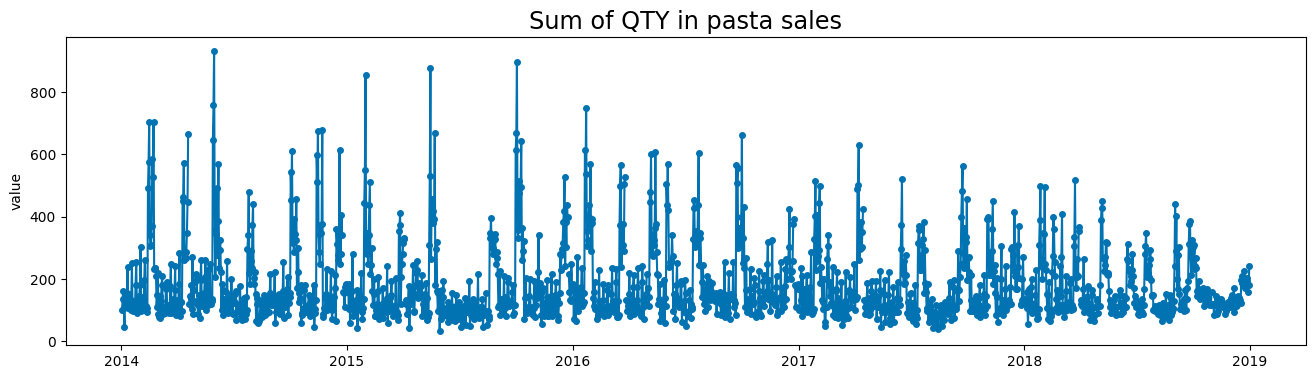

In [84]:
plot_series(y, title="Sum of QTY in pasta sales")

We are interested in long-term forecasting. We assume that our client, an italian pasta maker, has the historical data from years 2014-2017 and wants to forecast the sales for 2018. Such information is required e.g. to make contracts for long-term supply of raw materials and next year production plans. From ML perspective this hard, since there is only a single temporal train-test split with long horizon, instead of expanding window, but it's faster.

We will use the `evaluate_pasta_sales_model` function for evaluation.

**Exercise 9 (1 point)**

Implement the missing parts of the evaluation function:
1. Split `y` into training and testing set with time split. Test set starts at `2018-01-01`.
2. If user passes `X`, split it in the same way.
3. Impute the missing values in `y`, using `Imputer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.impute.Imputer.html)) with `ffill` strategy (copy last known value).
4. Train the model (remember to pass `X`) and perform prediction.
5. Evaluate it using MAE and MASE functions ([documentation](https://www.sktime.net/en/stable/api_reference/performance_metrics.html)). Print the results rounded to 2 decimal places.
6. Copy the code for `analyze_residuals` from exercise 3.

In [85]:
from typing import Optional

import numpy as np
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.impute import Imputer


def evaluate_pasta_sales_model(
    model,
    df: pd.Series,
    X: Optional[np.ndarray] = None,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    # print(df[df.index >= "2018-01-01"])

    y_train = df[df.index < "2018-01-01"]
    y_test = df[df.index >= "2018-01-01"]

    if X is not None:
        X_train = X[df.index < "2018-01-01"]
        X_test = X[df.index >= "2018-01-01"]
    else:
        X_train = None
        X_test = None

    # impute
    imputer = Imputer(method="ffill")
    # df = imputer.fit_transform(df)
    y_train = imputer.fit_transform(y_train)
    y_test = imputer.transform(y_test)

    # train and predict
    model.fit(y_train, X_train)
    fh = ForecastingHorizon(y_test.index, is_relative=False, freq="D")
    y_pred = model.predict(fh=fh, X=X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        # print(df[df.index >= "2018-01-01"])
        y_true = y_test[y_pred.index]
        plot_series(df, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        residuals = y_true - y_pred
        residuals.hist(bins=20)
        print("Residuals mean: ", np.mean(residuals))
        plt.title("Histogram of residuals")
        plt.show()

        anderson_test = anderson(residuals)
        print(f"Anderson-Darling test: {anderson_test}")
        print("=========================================")
        ljung_box_test = acorr_ljungbox(residuals, lags=[12], return_df=True)
        print(f"Ljung-Box test: {ljung_box_test}")


**Exercise 10 (1.5 points)**

Perform the forecasting using the following models:
- two baselines
- ETS with damped trend
- ARIMA
- SARIMA with 30-day seasonality
- ARIMAX
- SARIMAX with 30-day seasonality

For the best model also try the log, sqrt and Box-Cox transformations.

For the final model plot the forecasts and perform residuals analysis.

Comment:
- did you outperform the baseline?
- does the final model use seasonality and/or exogenous variables (data about promotions)?
- was it worth it to use the variance-stabilizing transformation?
- comment on the general behavior of the model on the test set, based on the forecast plot
- is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?

### Baselines

MAE: 71.54
MAPE: 0.52
MASE: 1.08


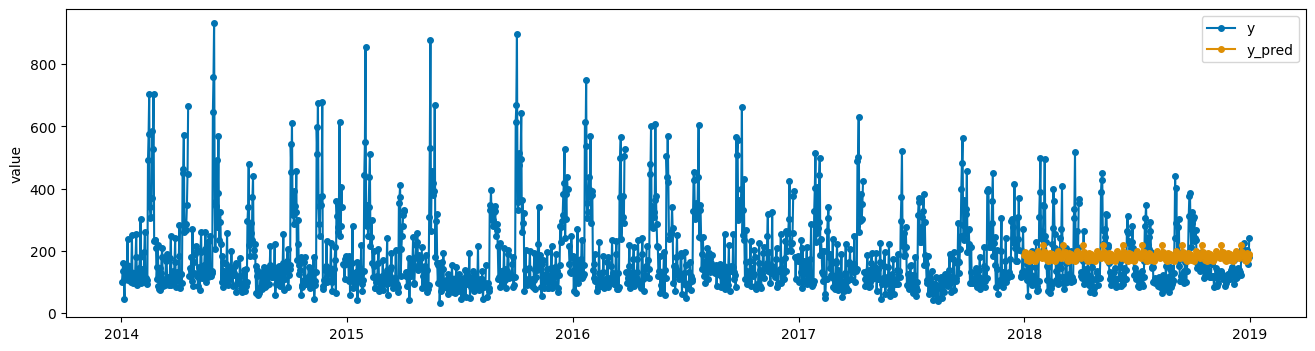

Residuals mean:  -20.365225332539207


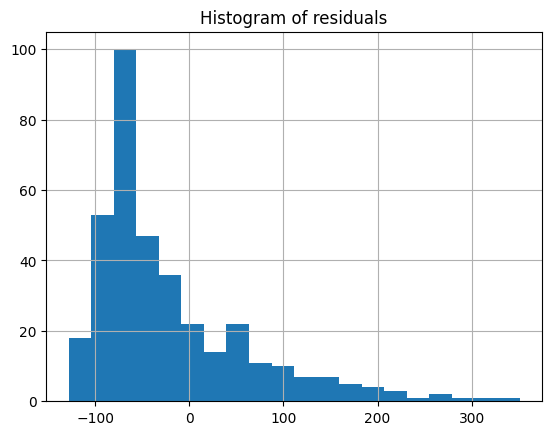

Anderson-Darling test: AndersonResult(statistic=18.631529879983646, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-20.365225332539207, scale=84.01075487852698)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  408.18692  6.982623e-80


In [86]:
model_mean = NaiveForecaster(strategy="mean", sp=32)
evaluate_pasta_sales_model(model_mean, y, plot_forecasts=True, analyze_residuals=True)

MAE: 93.76
MAPE: 0.68
MASE: 1.42


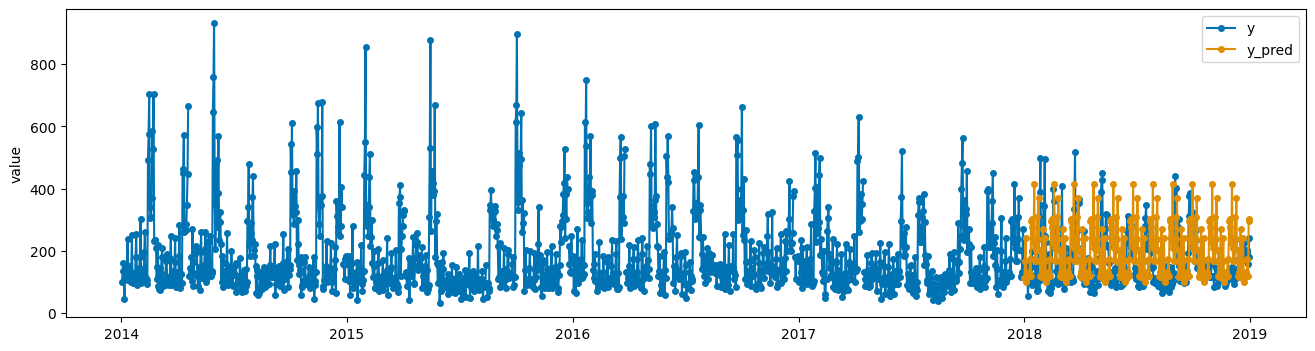

Residuals mean:  -32.98082191780822


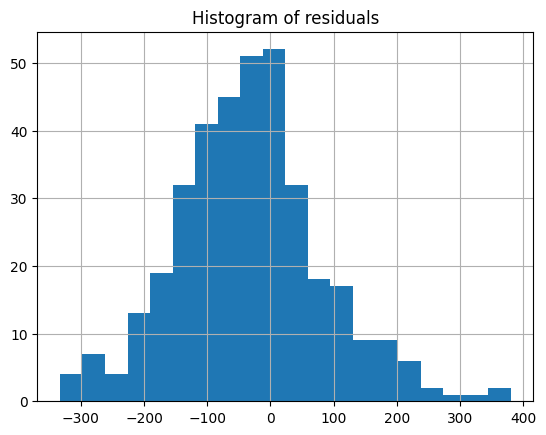

Anderson-Darling test: AndersonResult(statistic=1.0465429012403433, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-32.98082191780822, scale=115.9448626272517)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  231.57903  9.362989e-43


In [87]:
model_last = NaiveForecaster(strategy="last", sp=32)
evaluate_pasta_sales_model(model_last, y, plot_forecasts=True, analyze_residuals=True)

### ETS with damped trend

MAE: 64.99
MAPE: 0.44
MASE: 0.98


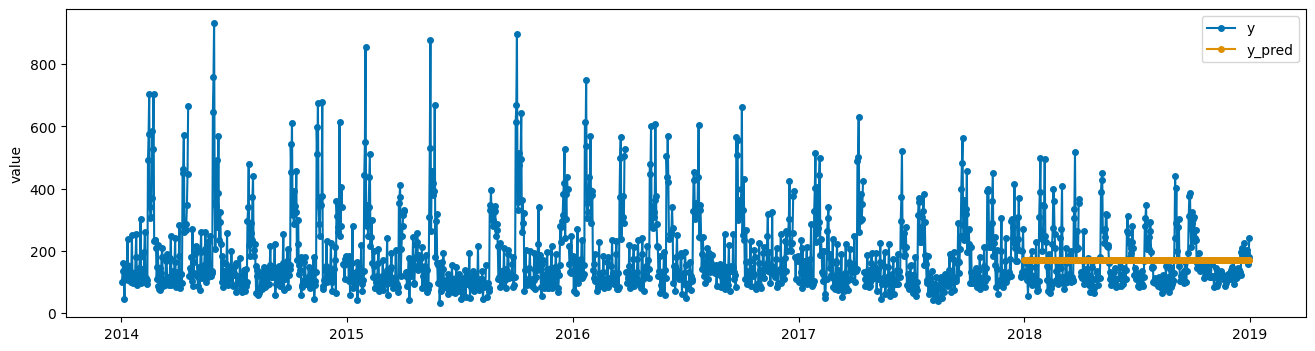

Residuals mean:  -5.79227897857485


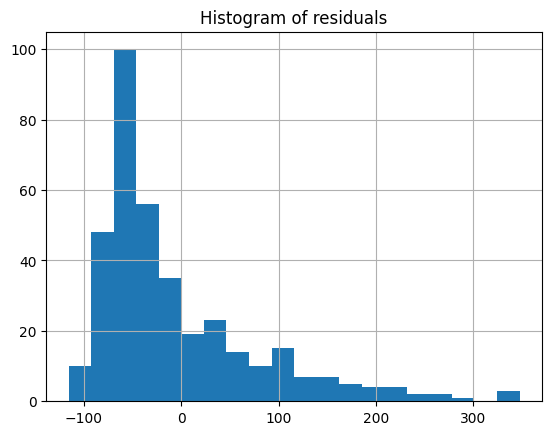

Anderson-Darling test: AndersonResult(statistic=20.166514435572026, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-5.79227897857485, scale=83.33275100407634)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  422.645149  6.021003e-83


In [88]:
model_ets = StatsForecastAutoETS(damped=True, season_length=30)
evaluate_pasta_sales_model(model_ets, y, plot_forecasts=True, analyze_residuals=True)

### ARIMA

MAE: 70.40
MAPE: 0.51
MASE: 1.07


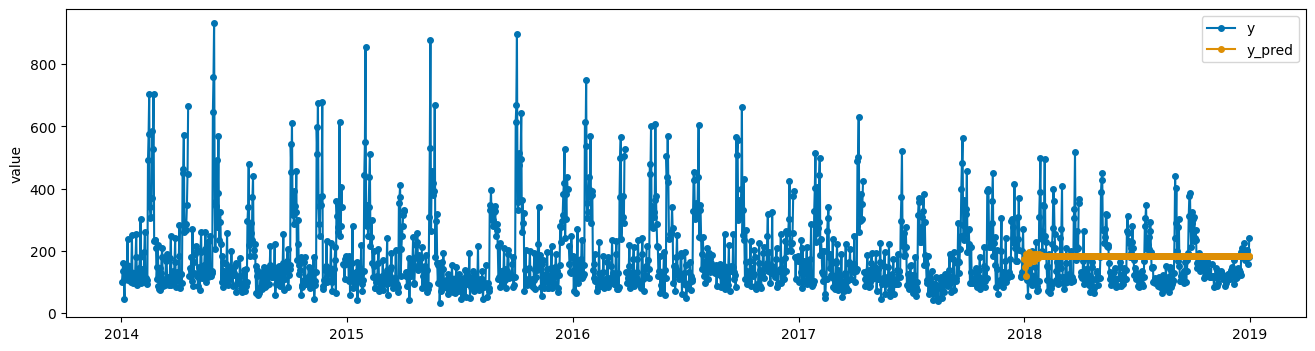

Residuals mean:  -19.81539008732455


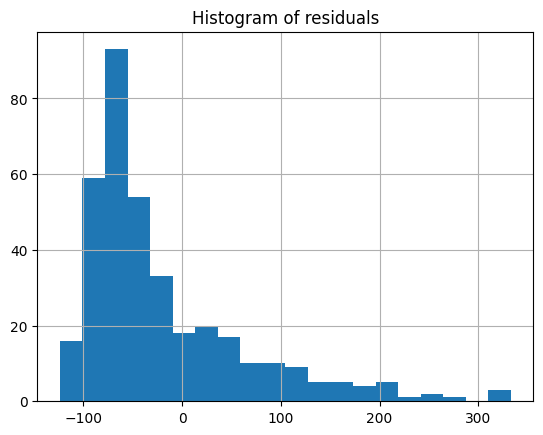

Anderson-Darling test: AndersonResult(statistic=19.72950978959193, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-19.81539008732455, scale=83.05890741312881)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  418.83857  3.861052e-82


In [89]:
model_arima = StatsForecastAutoARIMA(sp=12)
evaluate_pasta_sales_model(model_arima, y, plot_forecasts=True, analyze_residuals=True)

### SARIMA with 30-day seasonality

MAE: 69.94
MAPE: 0.51
MASE: 1.06


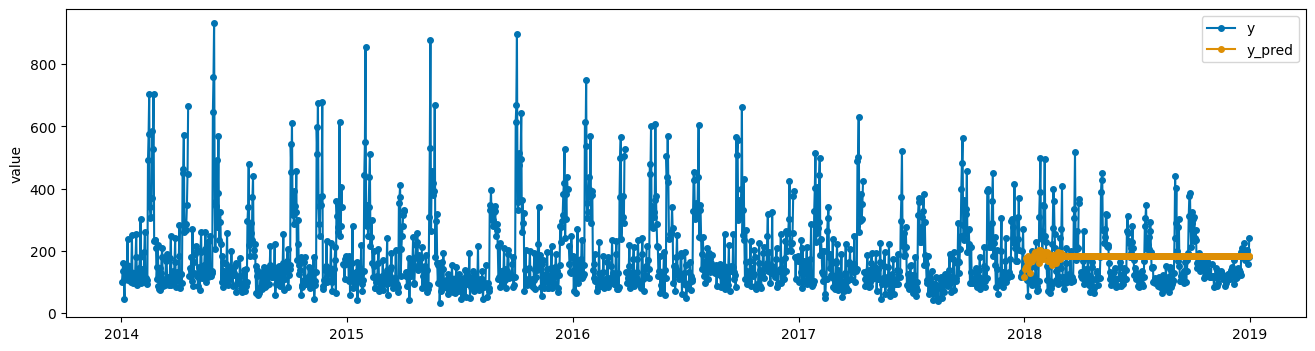

Residuals mean:  -19.286453827772124


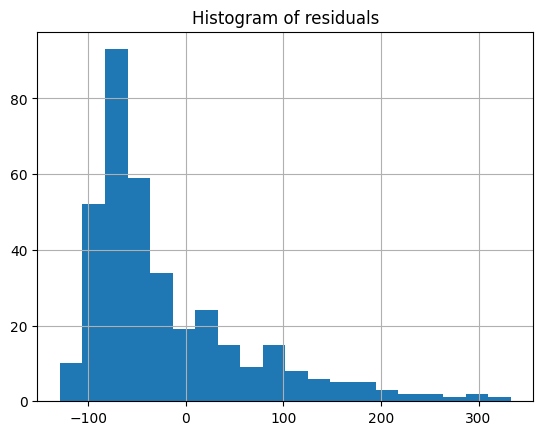

Anderson-Darling test: AndersonResult(statistic=18.752240980656552, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-19.286453827772124, scale=82.53766500439156)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  415.504509  1.965249e-81


In [90]:
model_sarima = StatsForecastAutoARIMA(sp=30, seasonal=True)
evaluate_pasta_sales_model(model_sarima, y, plot_forecasts=True, analyze_residuals=True)

### ARIMAX

MAE: 43.78
MAPE: 0.29
MASE: 0.66


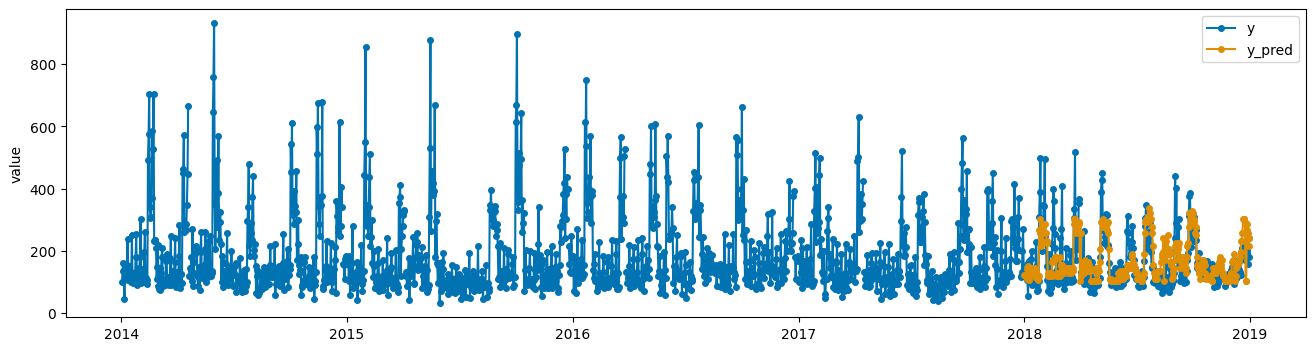

Residuals mean:  -6.96275554141845


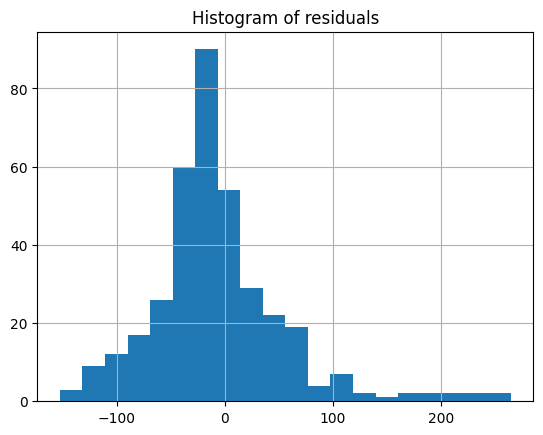

Anderson-Darling test: AndersonResult(statistic=7.696587652242329, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-6.96275554141845, scale=61.14965576576434)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  196.481707  1.734844e-35


In [91]:
model_arimax = StatsForecastAutoARIMA(sp=12)
evaluate_pasta_sales_model(model_arimax, y, X=x2, plot_forecasts=True, analyze_residuals=True)

### SARIMAX with 30-day seasonality

MAE: 43.94
MAPE: 0.29
MASE: 0.67


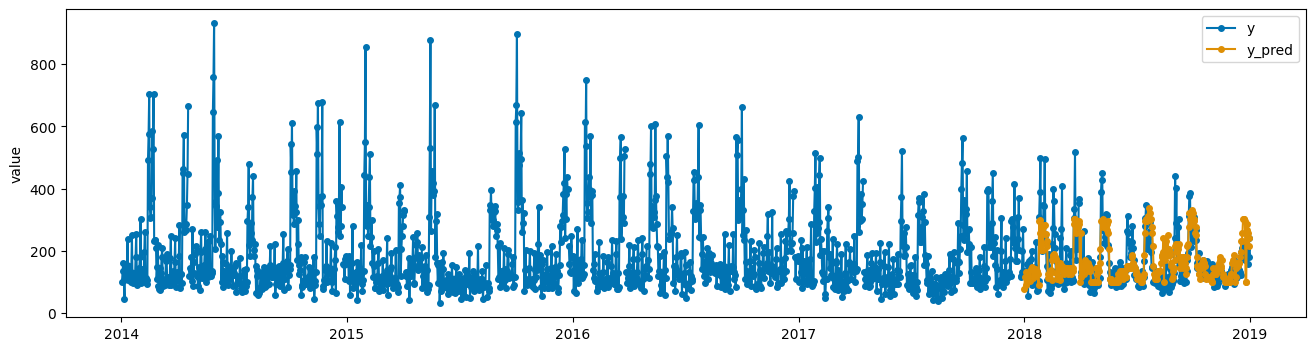

Residuals mean:  -5.453666414945035


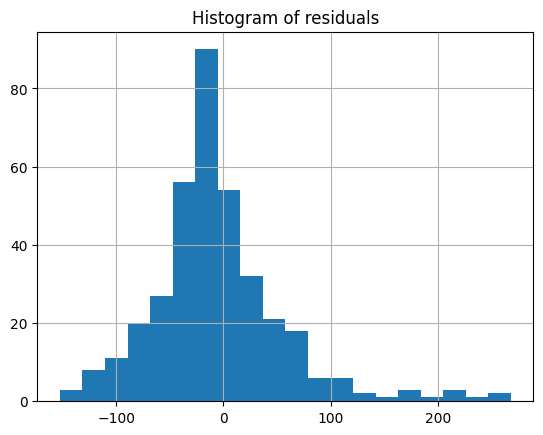

Anderson-Darling test: AndersonResult(statistic=6.520024934344292, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-5.453666414945035, scale=61.20955637327004)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  189.518382  4.718574e-34


In [92]:
model_sarima = StatsForecastAutoARIMA(sp=30, seasonal=True)
evaluate_pasta_sales_model(model_sarima, y, X=x2, plot_forecasts=True, analyze_residuals=True)

### Best with additional transformations

MAE: 40.56
MAPE: 0.25
MASE: 0.61


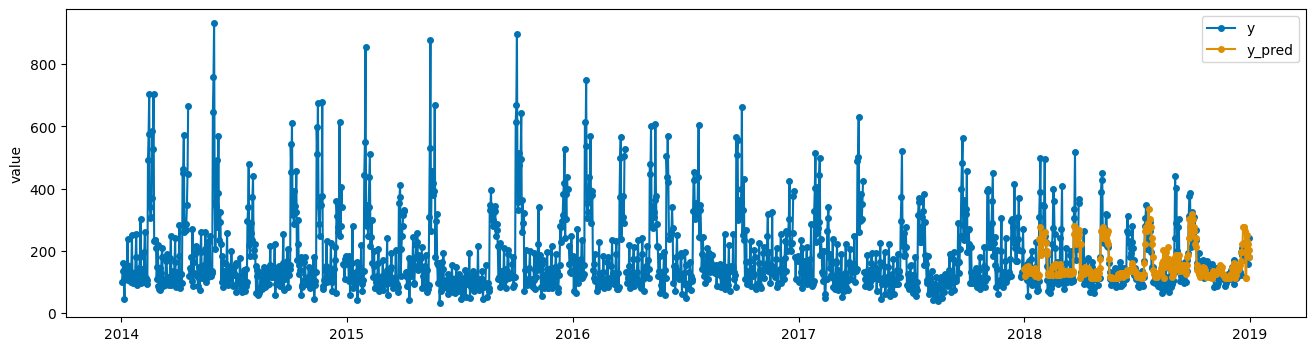

Residuals mean:  4.7706029149062505


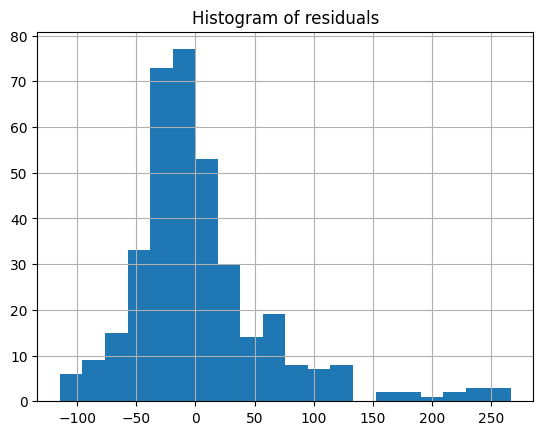

Anderson-Darling test: AndersonResult(statistic=13.622050509574251, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.7706029149062505, scale=60.585132891602655)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:       lb_stat     lb_pvalue
12  200.14826  3.039554e-36


In [93]:
pipe = make_pipeline(LogTransformer(), SqrtTransformer(), BoxCoxTransformer(), model_arimax)
evaluate_pasta_sales_model(pipe, y, X=x2, plot_forecasts=True, analyze_residuals=True)

### Comment:
- did you outperform the baseline?\
    **Yes. Baseline has mae around 71 or 93. But best model ARIMAX achieved mae 40.33.**
- does the final model use seasonality and/or exogenous variables (data about promotions)?\
    **Final model uses exogenous variables, but not seasonality.**
- was it worth it to use the variance-stabilizing transformation?\
    **Yes, it improved the result a little.**
- comment on the general behavior of the model on the test set, based on the forecast plot\
    **It tries to repeat previous behaviour. Mostly it cannot derive anything characteristic from past, so the result is flat. But when we add exegenous\
        variables it has some guideline where can occur peaks and it predicts in better fashion.**
- is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?\
    **Model passed Anderson-Darling test so it is normally distributed where mean is rather close to zero. So this model is unbiased.\
        But it didn't pass the Ljung-Box test, so the data is dependent.**

Exogenous variables can be expanded with feature engineering. For example, the behavior of clients is quite different during weekends and holidays. Typically sales rise quite sharply before and after days when stores are closed, and falls to exactly zero when they have to be closed.

**Exercise 11 (0.75 points)**

1. Create a list of variables for holidays using `HolidayFeatures` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.holiday.HolidayFeatures.html)):
   - use `country_holidays` function from the holidays library
   - remember that we are processing italian data, with country identifier `"IT"`
   - include weekends as holidays
   - create a single variable "is there a holiday" (`return_dummies` and `return_indicator` options)
2. Add those features to our exogenous variables `X`. Use `pd.merge` function, `left_index` and `right_index` options may be useful.
3. Train the ARIMAX model (or SARIMAX, if you detected seasonality before). Use the best transformation from the previous exercise.
4. Comment on the results, and compare them to the previous ones.

In [94]:
from holidays import country_holidays
import sktime.transformations.series.holiday as holiday

print(country_holidays("IT"))

{'country': IT, 'expand': True, 'language': None, 'market': None, 'observed': True, 'subdiv': None, 'years': set()}


In [ ]:
transformer = holiday.HolidayFeatures(
   calendar=country_holidays(country="IT"),
   return_categorical=True,
   include_weekend=True, 
   return_dummies=True,
   return_indicator=True)  

print(transformer)

HolidayFeatures(calendar=holidays.country_holidays('IT'), include_weekend=True,
                return_categorical=True, return_indicator=True)


In [97]:
x3 = x2.copy()
x3.index = x3.index.to_timestamp()
x_holidays = transformer.fit_transform(x3)
x_holidays = x_holidays[["holiday"]]
x_holidays["holiday"] = x_holidays["holiday"].map(lambda x: 0 if x == "no_holiday" else 1)
x_holidays = x_holidays["holiday"]
x_holidays = x_holidays.to_period(freq="D")

x4 = pd.merge(x2, x_holidays, left_index=True, right_index=True)

x_sum = x4.copy()
x_sum = x_sum.sum(axis=1)

MAE: 40.43
MAPE: 0.25
MASE: 0.61


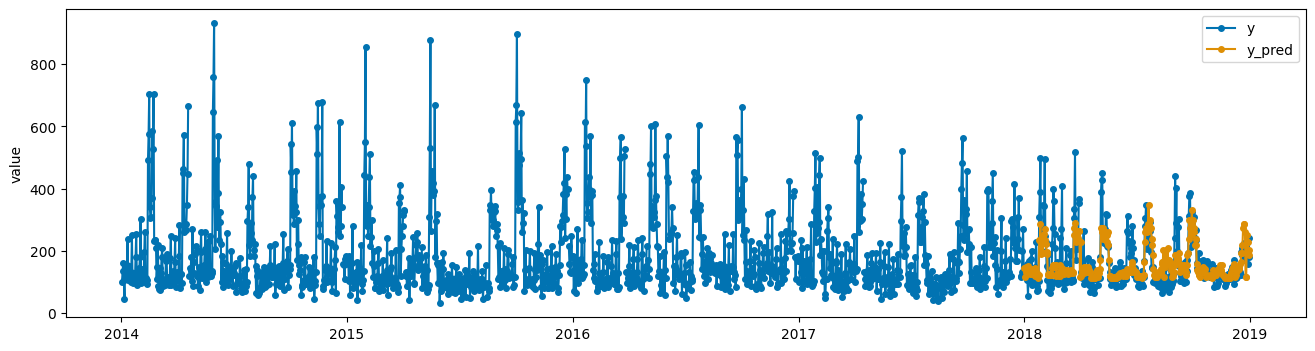

Residuals mean:  4.742281761509061


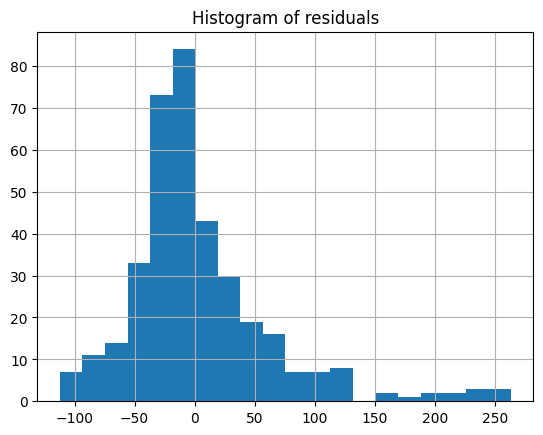

Anderson-Darling test: AndersonResult(statistic=13.135518361491677, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.742281761509061, scale=60.08682627565809)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Ljung-Box test:        lb_stat     lb_pvalue
12  199.478412  4.178890e-36


In [98]:
evaluate_pasta_sales_model(pipe, y, X=x_sum, plot_forecasts=True, analyze_residuals=True)

Comment:\
**Results are very similar to the last ones in previous task. MAE score has decreased a little.** 